# Worksheet 17

Name: Jacob Stein
UID: U33341709

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

For a streaming platform that uses only a binary "like" or "dislike" system rather than a detailed 1-5 rating scale, you can still build an effective recommender system. Here’s a step-by-step approach:

### a) Building a Binary Recommender System:

#### Step 1: Data Collection
- **Collect Data:** Gather user interactions with content in the form of "like" or "dislike." This binary data will form the foundation of your recommendation model.

#### Step 2: User Profiling
- **User Profiles:** Construct user profiles based on their likes and dislikes. Each profile will be a binary vector where each element represents whether the user liked (1) or disliked (0) a given piece of content.

#### Step 3: Similarity Measurement
- **Calculate Similarity:** Use a similarity metric to assess the similarity between users based on their binary profiles. Commonly used metrics in binary systems include Jaccard similarity, cosine similarity, or Hamming distance. This step helps to identify users with similar preferences.

#### Step 4: Recommendation Generation
- **Generate Recommendations:** For each user, find other users who are most similar to them and look at the content they have liked that the target user has not yet interacted with. Recommend these unwatched items that have been liked by similar users. This approach assumes that if a user has similar tastes to another, they are likely to enjoy content liked by the other user.

#### Step 5: Implementation of the Recommendation Engine
- **Matrix Representation:** Implement a binary matrix representation where rows represent users and columns represent movies, with cells filled with 1 (like) or 0 (dislike). This matrix will be sparse as not all users will have interacted with all content.

#### Step 6: Algorithm Optimization
- **Efficiency Considerations:** Given the potential size of the matrix, use efficient data structures like sparse matrices. Additionally, implement batch processing and possibly parallel computing for scalability when processing large user bases or content libraries.

#### Step 7: Feedback Loop
- **Incorporate Feedback:** Continuously update the user profiles and similarity metrics with new user interaction data. This ensures that the recommender system adapts to changing user preferences and the introduction of new content.

This approach leverages the simplicity of binary data while employing methodologies common in more complex systems, thus ensuring both efficiency and effectiveness in recommending content to users.

b) Describe 3 challenges of building a recommender system

Building a recommender system presents several challenges, especially as they scale to handle more data and more complex user behaviors. Here are three key challenges:

### 1. Data Sparsity
- **Issue:** In many recommender systems, particularly those dealing with items such as movies, books, or products, there is often a large inventory but each user has interacted with only a small fraction of that inventory. This results in a sparse matrix where the majority of the entries are empty (indicating no interaction). 
- **Impact:** Data sparsity makes it difficult to find reliable similarities between users or items because there isn't enough overlap in their interaction patterns. This can lead to weaker or less accurate recommendations.

### 2. Scalability
- **Issue:** As the number of users and items grows, the computational load and memory requirements to process recommendations increase dramatically. The complexity rises not only from the growing size of the data but also from the need to update recommendations in real time or near-real time.
- **Impact:** Ensuring that the recommender system can scale efficiently requires sophisticated algorithms and infrastructure. Failure to address scalability can result in slow response times and outdated recommendations, leading to a poor user experience.

### 3. Cold Start Problem
- **Types:**
  - **User Cold Start:** When new users join the platform, there is insufficient data on their preferences, making it difficult to provide personalized recommendations.
  - **Item Cold Start:** New items added to the platform similarly lack user interaction data, making it challenging to recommend them effectively.
- **Impact:** The cold start problem can result in generic or irrelevant recommendations for new users or items. It can diminish user satisfaction and engagement, especially for new users who are experiencing the service for the first time.

### Addressing These Challenges:
- **For Data Sparsity:** Techniques such as dimensionality reduction (e.g., using singular value decomposition) or leveraging content-based filtering alongside collaborative filtering can help mitigate the effects of sparse data.
- **For Scalability:** Implementing more efficient data structures, such as sparse matrices, and using distributed computing frameworks can help handle large datasets. Algorithms like matrix factorization or neural network-based approaches can be optimized for performance.
- **For Cold Start:** Incorporating hybrid models that use both content-based and collaborative approaches can alleviate this problem. For new users, demographic information or explicit preference gathering at sign-up can bootstrap the recommendation process. For new items, attributes of the items can be used to create initial recommendations based on similar, well-established items.

By recognizing and addressing these challenges, developers can significantly enhance the effectiveness and user satisfaction of recommender systems.

c) Why is SVD not an option for collaborative filtering?

The Singular Value Decomposition (SVD) is a powerful linear algebra tool used for dimensionality reduction and has applications in signal processing and statistics. In the context of collaborative filtering, SVD can indeed be used to extract latent factors that explain observed ratings. However, there are certain challenges and limitations when using SVD directly for collaborative filtering on typical user-item rating matrices, especially in raw form. Here's why SVD might not always be the best option:

### 1. Handling Sparse Data
- **Issue:** User-item matrices in collaborative filtering are typically extremely sparse because most users only interact with a small fraction of available items. Traditional SVD requires a complete matrix (i.e., no missing values) to compute the decomposition.
- **Impact:** Direct application of SVD to a sparse matrix filled with zeros (for missing values) can lead to misleading results because the algorithm will interpret uninteracted items as negative feedback (zero ratings), which is not usually the intention in recommendation systems.

### 2. Computational Complexity
- **Issue:** SVD is computationally intensive, especially as the size of the data grows. The complexity of computing SVD is \(O(min(m^2 \cdot n, m \cdot n^2))\), where \(m\) is the number of users and \(n\) is the number of items.
- **Impact:** For very large matrices, which are common in real-world recommender systems, running SVD can be prohibitively slow and resource-demanding, making it less practical for dynamic systems where the dataset is constantly updated with new users or items.

### 3. Scalability and Dynamic Updates
- **Issue:** SVD is not inherently designed to handle updates to the data matrix efficiently. Adding new users or items or updating existing ratings typically requires a complete re-computation of the SVD.
- **Impact:** In an environment where new data are constantly being added, the need to frequently recompute the full decomposition makes SVD less suitable for real-time recommendations.

### Alternative Approaches in Collaborative Filtering
- **Matrix Factorization Techniques:** Techniques like Alternating Least Squares (ALS) and Stochastic Gradient Descent (SGD) based matrix factorization are specifically designed to handle the sparsity and scalability issues inherent in collaborative filtering. These methods approximate the user-item matrix and allow for incremental updates, making them more suitable for large-scale, dynamic systems.
- **Regularized SVD:** Modifications of SVD, such as Regularized SVD or SVD++, have been developed to handle sparse datasets better. These techniques incorporate regularization terms to prevent overfitting and can deal more effectively with the absence of data.
- **Implicit Feedback Models:** For datasets where explicit ratings are sparse or unavailable, models that can incorporate implicit feedback (like views, clicks, or purchases) are useful. Techniques that factor in this type of data help address the challenges of traditional SVD in capturing user preferences from sparse and indirect interactions.

While traditional SVD has its limitations, these alternative techniques and adaptations offer more practical solutions for building efficient and scalable recommender systems in real-world settings.

d) Use the code below to train a recommender system on a dataset of amazon movies

Kaggle RMSE =  1.4196605255493122


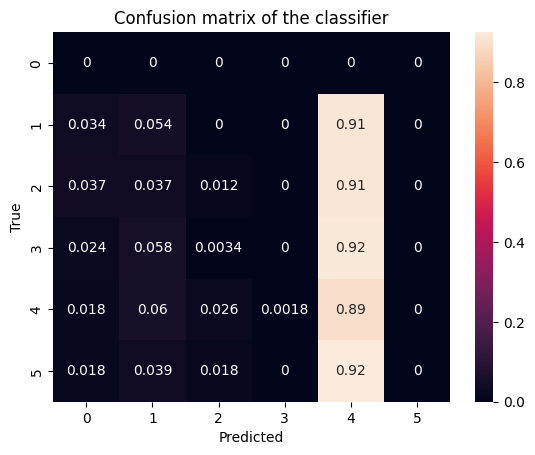

In [8]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

import warnings
warnings.filterwarnings('ignore')

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
param_grid = ParamGridBuilder().addGrid(
        als.rank, [10, 50]).addGrid(
        als.regParam, [.1]).addGrid(
        als.maxIter, [10]).build()
evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Score", 
        predictionCol="prediction")
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

# rec_sys = als.fit(df)
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()

X_test_merged = X_test_processed.merge(rec, on=['UserId_fact', 'ProductId_fact'], how='left')

average_score = init_df['Score'].mean()
X_test_merged['prediction'] = X_test_merged['prediction'].fillna(average_score)

print("Kaggle RMSE = ", mean_squared_error(Y_test, X_test_merged['prediction'], squared=False))

cm = confusion_matrix(Y_test, X_test_merged['prediction'].astype(int), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test, X_test_merged['prediction'])
print("Mean Absolute Error (MAE) = ", mae)

Mean Absolute Error (MAE) =  1.101717935767393
